In [1]:
# This code is to train the entire R Peak Detection algorithm as well as
# Test it on a hold out set of three patients that will contain a mix of ECG
# Signals. This will allow us to see how well it will perform in practise

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
# For the LSTM
import keras
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, GlobalMaxPool1D, Dense, Dropout, Flatten
# For data splitting
from sklearn.model_selection import train_test_split
# Potentially for analysing probability output distribution
from scipy.signal import find_peaks
from scipy import interpolate

Using TensorFlow backend.


In [3]:
def normalise(x):
    mean = np.mean(x)
    x -= mean
    std = np.std(x)
    x /= std
    return (x)

In [4]:
# Test set is full of patients: 100, 105, 116, 215, 232
# All the other patients can be put into the training set

train = [101,103,105,107,109,112,114,118,121,123,200,202,205,208,210,213,215,219,221,223,230]

final_x = np.zeros((len(train), 65,10000,6), dtype=np.float32)
final_y = np.zeros((len(train), 65, 10000), dtype=np.int32)

for o,i in enumerate(train):
    
    print(i)
    
    with open('adb de-noised/{}_de-noised.pkl'.format(i), 'rb') as f:
        smoothed = pickle.load(f)
    
    with open('adb final labels/adb peaks/{}_peaks.pkl'.format(i), 'rb') as f:
        peaks = pickle.load(f)
        
    lead_1 = np.zeros((smoothed.shape[0],))
    lead_2 = np.zeros((smoothed.shape[0],))
    
    for c,dual_point in enumerate(smoothed):
        lead_1[c] = dual_point[0]
        lead_2[c] = dual_point[1]
        
    time_stamp = 10000
    
    detrend_lead_1 = np.asarray([lead_1[i: i + time_stamp] for i in range(0, len(lead_1), time_stamp)])
    detrend_lead_2 = np.asarray([lead_2[i: i + time_stamp] for i in range(0, len(lead_2), time_stamp)])
    
    patient_x = np.zeros((65,10000,6), dtype=np.float32)
    
    knot = np.arange(10,10000, 100)
    
    for index,chunk in enumerate(detrend_lead_1):
        
        tck_1 = interpolate.splrep(list(range(time_stamp)), detrend_lead_1[index],t=knot, k = 3, task = -1)
        new_lead_1 = np.array(np.array(detrend_lead_1[index]) - np.array(interpolate.splev(list(range(time_stamp)), tck_1)), dtype = np.float32)
        tck_2 = interpolate.splrep(list(range(time_stamp)), detrend_lead_2[index],t=knot, k = 3, task = -1)
        new_lead_2 = np.array(np.array(detrend_lead_2[index]) - np.array(interpolate.splev(list(range(time_stamp)), tck_2)), dtype = np.float32)
        smoothed = np.array(normalise(new_lead_1),dtype=np.float32)
        smoothed2 = np.array(normalise(new_lead_2),dtype=np.float32)
        deriv = np.array(np.gradient(smoothed), dtype=np.float32)
        deriv = np.array(normalise(deriv),dtype=np.float32)
        deriv2 = np.array(np.gradient(smoothed2),dtype=np.float32)
        deriv2 = np.array(normalise(deriv2),dtype=np.float32)
        deriv_2 = np.array(np.gradient(deriv),dtype=np.float32)
        deriv_2 = np.array(normalise(deriv_2),dtype=np.float32)
        deriv2_2 = np.array(np.gradient(deriv2),dtype=np.float32)
        deriv2_2 = np.array(normalise(deriv2_2),dtype=np.float32)

        x = np.hstack((smoothed,deriv))
        x = np.hstack((x,deriv_2))
        x = np.hstack((x,smoothed2))
        x = np.hstack((x,deriv2))
        x = np.hstack((x,deriv2_2))

        new_x = np.zeros((10000, 6),dtype=np.float32)

        for l in range(smoothed.shape[0]):
            temp = np.array([smoothed[l], deriv[l], deriv_2[l], smoothed2[l], deriv2[l], deriv2_2[l]], dtype=np.float32)
            new_x[l] = temp
            
        patient_x[index] = new_x
        
    y = np.zeros((len(lead_1),))

    buffer = 2
    
    # Set the labels to true in buffer region
    for k in peaks:
        y[k - buffer: k + buffer] = 1
    
    patient_y = np.asarray([y[i: i + time_stamp] for i in range(0, len(y), time_stamp)], dtype=np.int32)
    
    # Now append these to the total
    final_x[o] = patient_x
    final_y[o] = patient_y

101
103
105
107
109
112
114
118
121
123
200
202
205
208
210
213
215
219
221
223
230


In [5]:
print(len(final_x))
print(len(final_x[0]))

21
65


In [6]:
final_x = np.array(final_x)

In [7]:
print(final_x.shape)

(21, 65, 10000, 6)


In [8]:
print(final_x[1][0])

[[-0.34905714  1.2638214  -0.4307238  -0.31873462  0.9948436  -0.30892366]
 [-0.05361141  1.1029708  -0.6215784  -0.04855742  0.8677089  -0.44579515]
 [ 0.16665316  0.7996554  -0.7631728   0.15259154  0.6279866  -0.5472967 ]
 ...
 [ 0.18009937  0.39929244  0.03904104  0.32236317  0.37895793 -0.0291106 ]
 [ 0.27519748  0.41387483  0.02961862  0.42685577  0.3437856  -0.09210816]
 [ 0.3737276   0.42121762  0.01992     0.5092235   0.3030365  -0.0988878 ]]


In [9]:
total = (final_x.shape[0] * final_x.shape[1] * final_x.shape[2])
test_x = np.reshape(final_x, (total, final_x.shape[-1]))

In [10]:
test_x.shape

(13650000, 6)

In [11]:
test_x[650000]
# Re-shaping has worked so now do same for labels

array([-0.34905714,  1.2638214 , -0.4307238 , -0.31873462,  0.9948436 ,
       -0.30892366], dtype=float32)

In [12]:
final_y = np.array(final_y)

In [13]:
test_y = np.reshape(final_y, (total,))

In [14]:
test_y.shape

(13650000,)

In [15]:
test_y[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [16]:
def proportions(y):
    test = list(y)
    points = test.count(1)
    print(points/len(test))
    print((1 - points/len(test)))
    
proportions(test_y)

0.014802051282051282
0.9851979487179487


In [17]:
initializer = "glorot_uniform"
model = Sequential()
model.add(Dense(256, activation ='relu', input_shape = (6,)))
model.add(Dense(1, activation='sigmoid'))
opt = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=opt, loss = 'binary_crossentropy', metrics=["binary_accuracy", "mae"])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               1792      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________


In [18]:
x_train, x_val, y_train, y_val = train_test_split(test_x, test_y, test_size=0.25, shuffle = True)
proportions(y_train)
proportions(y_val)

0.014826568986568986
0.985173431013431
0.014728498168498168
0.9852715018315018


In [19]:
x_train.shape

(10237500, 6)

In [51]:
history = model.fit(x_train, y_train, verbose=True, batch_size = 50000, validation_data = (x_val, y_val), epochs = 50)

Train on 10237500 samples, validate on 3412500 samples
Epoch 1/50
10237500/10237500 [==============================] - 11s 1us/step - loss: 0.0135 - binary_accuracy: 0.9949 - mae: 0.0074 - val_loss: 0.0123 - val_binary_accuracy: 0.9953 - val_mae: 0.0071
Epoch 2/50
10237500/10237500 [==============================] - 11s 1us/step - loss: 0.0122 - binary_accuracy: 0.9953 - mae: 0.0071 - val_loss: 0.0122 - val_binary_accuracy: 0.9953 - val_mae: 0.0070
Epoch 3/50
10237500/10237500 [==============================] - 11s 1us/step - loss: 0.0120 - binary_accuracy: 0.9954 - mae: 0.0070 - val_loss: 0.0120 - val_binary_accuracy: 0.9954 - val_mae: 0.0070
Epoch 4/50
10237500/10237500 [==============================] - 11s 1us/step - loss: 0.0119 - binary_accuracy: 0.9954 - mae: 0.0070 - val_loss: 0.0119 - val_binary_accuracy: 0.9954 - val_mae: 0.0069
Epoch 5/50
10237500/10237500 [==============================] - 11s 1us/step - loss: 0.0118 - binary_accuracy: 0.9955 - mae: 0.0069 - val_loss: 0.011

Epoch 42/50
10237500/10237500 [==============================] - 11s 1us/step - loss: 0.0106 - binary_accuracy: 0.9960 - mae: 0.0062 - val_loss: 0.0106 - val_binary_accuracy: 0.9959 - val_mae: 0.0062
Epoch 43/50
10237500/10237500 [==============================] - 11s 1us/step - loss: 0.0106 - binary_accuracy: 0.9960 - mae: 0.0062 - val_loss: 0.0106 - val_binary_accuracy: 0.9960 - val_mae: 0.0062
Epoch 44/50
10237500/10237500 [==============================] - 11s 1us/step - loss: 0.0105 - binary_accuracy: 0.9960 - mae: 0.0061 - val_loss: 0.0106 - val_binary_accuracy: 0.9959 - val_mae: 0.0062
Epoch 45/50
10237500/10237500 [==============================] - 11s 1us/step - loss: 0.0105 - binary_accuracy: 0.9960 - mae: 0.0061 - val_loss: 0.0106 - val_binary_accuracy: 0.9960 - val_mae: 0.0061
Epoch 46/50
10237500/10237500 [==============================] - 12s 1us/step - loss: 0.0105 - binary_accuracy: 0.9960 - mae: 0.0061 - val_loss: 0.0105 - val_binary_accuracy: 0.9960 - val_mae: 0.0061


In [65]:
# Get a confusion matrix
preds = model.predict(x_val, verbose = True)

preds = preds.reshape((preds.shape[0],))

3412500/3412500 [==============================] - 72s 21us/step


In [66]:
from sklearn.metrics import confusion_matrix

preds[preds > 0.5] = 1
preds[preds <= 0.5] = 0

print(confusion_matrix(y_val,preds))

[[3357529    4710]
 [   9018   41243]]


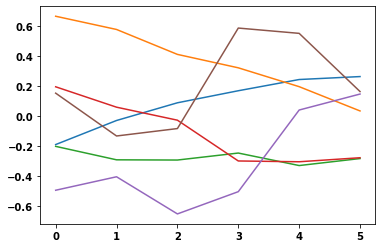

In [76]:
plt.plot(final_x[0][0][:6])

In [68]:
confusion = confusion_matrix(y_val,preds)
with open('Dense R Peak Results/Non-Weighted/Confusion.pkl'.format(str(i)), 'wb') as f:
    pickle.dump(confusion,f)

In [67]:
with open('Dense R Peak Results/Non-Weighted/History.pkl'.format(str(i)), 'wb') as f:
    pickle.dump(history,f)
    
#model.save("RNN R Peak Detection Model_reduce_set.h5")

In [43]:
# Test set is full of patients: 100, 105, 116, 215, 232
# All the other patients can be put into the training set

test = [100]

test_x = np.zeros((len(test), 65,10000,6), dtype=np.float32)
test_y = np.zeros((len(test), 65, 10000), dtype=np.int32)

for o,i in enumerate(test):
    
    print(i)
    
    with open('adb de-noised/{}_de-noised.pkl'.format(i), 'rb') as f:
        smoothed = pickle.load(f)
    
    with open('adb final labels/adb peaks/{}_peaks.pkl'.format(i), 'rb') as f:
        peaks = pickle.load(f)
        
    lead_1 = np.zeros((smoothed.shape[0],))
    lead_2 = np.zeros((smoothed.shape[0],))
    
    for c,dual_point in enumerate(smoothed):
        lead_1[c] = dual_point[0]
        lead_2[c] = dual_point[1]
        
    time_stamp = 10000
    
    detrend_lead_1 = np.asarray([lead_1[i: i + time_stamp] for i in range(0, len(lead_1), time_stamp)])
    detrend_lead_2 = np.asarray([lead_2[i: i + time_stamp] for i in range(0, len(lead_2), time_stamp)])
    
    patient_x = np.zeros((65,10000,6), dtype=np.float32)
    
    knot = np.arange(10,10000, 100)
    
    for index,chunk in enumerate(detrend_lead_1):
        
        tck_1 = interpolate.splrep(list(range(time_stamp)), detrend_lead_1[index],t=knot, k = 3, task = -1)
        new_lead_1 = np.array(np.array(detrend_lead_1[index]) - np.array(interpolate.splev(list(range(time_stamp)), tck_1)), dtype = np.float32)
        tck_2 = interpolate.splrep(list(range(time_stamp)), detrend_lead_2[index],t=knot, k = 3, task = -1)
        new_lead_2 = np.array(np.array(detrend_lead_2[index]) - np.array(interpolate.splev(list(range(time_stamp)), tck_2)), dtype = np.float32)
        smoothed = np.array(normalise(new_lead_1),dtype=np.float32)
        smoothed2 = np.array(normalise(new_lead_2),dtype=np.float32)
        deriv = np.array(np.gradient(smoothed), dtype=np.float32)
        deriv = np.array(normalise(deriv),dtype=np.float32)
        deriv2 = np.array(np.gradient(smoothed2),dtype=np.float32)
        deriv2 = np.array(normalise(deriv2),dtype=np.float32)
        deriv_2 = np.array(np.gradient(deriv),dtype=np.float32)
        deriv_2 = np.array(normalise(deriv_2),dtype=np.float32)
        deriv2_2 = np.array(np.gradient(deriv2),dtype=np.float32)
        deriv2_2 = np.array(normalise(deriv2_2),dtype=np.float32)

        x = np.hstack((smoothed,deriv))
        x = np.hstack((x,deriv_2))
        x = np.hstack((x,smoothed2))
        x = np.hstack((x,deriv2))
        x = np.hstack((x,deriv2_2))

        new_x = np.zeros((10000, 6),dtype=np.float32)

        for l in range(smoothed.shape[0]):
            temp = np.array([smoothed[l], deriv[l], deriv_2[l], smoothed2[l], deriv2[l], deriv2_2[l]], dtype=np.float32)
            new_x[l] = temp
            
        patient_x[index] = new_x
        
    y = np.zeros((len(lead_1),))

    buffer = 3
    
    # Set the labels to true in buffer region
    for k in peaks:
        y[k - buffer: k + buffer] = 1
    
    patient_y = np.asarray([y[i: i + time_stamp] for i in range(0, len(y), time_stamp)], dtype=np.int32)
    
    # Now append these to the total
    test_x[o] = patient_x
    test_y[o] = patient_y

100


In [44]:
test_x = np.array(test_x).reshape(650000,6)

In [45]:
test_y = np.array(test_y).reshape(650000,)

In [46]:
pred = model.predict(test_x, verbose = True)

650000/650000 [==============================] - 14s 22us/step


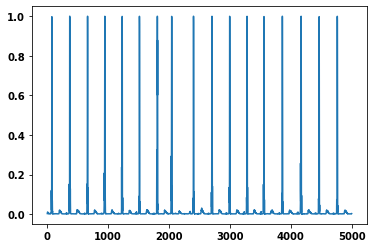

In [47]:
plt.plot(pred[:5000])

In [48]:
pred = pred.reshape((pred.shape[0],))

In [49]:
def accuracy_metric(new_prob_peaks, peaks):
    # Need to find the accuracy of this height self-similarity combo

    sample_window = 2
    counts = 0

    temp_list = list(new_prob_peaks)

    # Loop over the true annotated peaks as well as the predicted peaks
    for true_peak in peaks:
        for predicted_peak in temp_list:

            # If they are within the sample window either side of the true peak then allow it as a count for our case
            if ((predicted_peak >= (true_peak - sample_window)) and (predicted_peak <= (true_peak + sample_window))):
                counts += 1
                # Now remove this peak from the list as it is one-to-one relation so cannot be used again
                temp_list.remove(predicted_peak)
                # Now break from the for loop so we do not do the other components
                break
            else:
                continue
        
    accuracy = (counts/len(new_prob_peaks))
    missing = abs(len(peaks) - round(accuracy*len(new_prob_peaks)))
    wrong = (missing + round((1-accuracy) * len(new_prob_peaks)))
    return wrong

1617
3120
2273


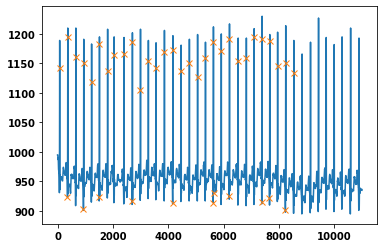

In [50]:
prob_peaks, _ = find_peaks(pred, height = 0.05, distance = 10)
new_prob_peaks = prob_peaks[lead_1[prob_peaks] > 0]
accuracy = accuracy_metric(new_prob_peaks, peaks)
print(accuracy)

print(len(new_prob_peaks))

print(len(peaks))

# Plot results
plt.plot(lead_1[:11000])
temp = new_prob_peaks[:41]
plt.plot(temp, lead_1[temp], "x")

In [30]:
# Find indexes of elements that are 0.5